In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt

## Fashion MNIST

In [2]:
# defining transformation
transform = transforms.Compose([transforms.ToTensor()])

# load the training
full_train = datasets.FashionMNIST(root='../data', download=True, train=True, transform=transform)

In [3]:
full_loader = torch.utils.data.DataLoader(full_train, batch_size=32, shuffle=False)

## Calculating Mean and STD Dev for FashionMNIST

In [ ]:
next(iter(full_loader))[0].shape

torch.Size([32, 1, 28, 28])

In [5]:
# sum_pixels = 0.0
# sum_squared_pixels = 0.0

# for images, _ in full_loader:
#     sum_pixels += images.sum()
#     sum_squared_pixels += (images ** 2).sum()

# # Total number of pixels
# total_pixels = len(full_train) * 28 * 28

# # Compute mean and std
# mean = sum_pixels / total_pixels
# std = torch.sqrt((sum_squared_pixels / total_pixels) - mean ** 2)

# print('Mean:', mean.item())
# print('Std:', std.item())
# # Mean: 0.2860404849052429
# # Std: 0.35302457213401794

## Transform with correct Mean and std_dev

In [6]:
# defining transformation
mean = 0.286040484905
std = 0.3530245721340
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])
transform = transforms.Compose([transforms.ToTensor()]) # Not normalizing as AE

# load the training and test data
trainset = datasets.FashionMNIST(root='../data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST(root='../data', download=True, train=False, transform=transform)

In [7]:
class_names = trainset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False)
valid_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

## Visualizing Dataset

Class name: Ankle boot


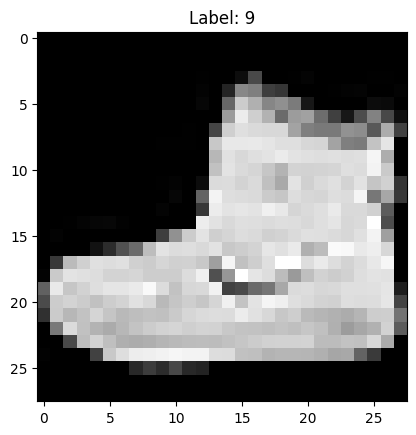

In [9]:
images, labels = next(iter(train_loader))
idx = 0
image = images[idx]
class_name = class_names[labels[idx].item()]
print(f'Class name: {class_name}')
plt.imshow(image.numpy().squeeze(), cmap='gray')
plt.title(f'Label: {labels[idx].item()}')
plt.show()

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
	torch.cuda.manual_seed(42)
else:
	torch.manual_seed(42)
    
print(device)

cuda


## Stacked Autoencoder

In [11]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 30)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(30, 100)
        self.fc2 = nn.Linear(100, 28 * 28)
        self.reshape = nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 
        x = self.reshape(x)
        return x

class StackedAutoEncoder(nn.Module):
    def __init__(self):
        super(StackedAutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x, y = None):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Model Initialization

In [12]:
stacked_ae = StackedAutoEncoder().to(device=device)
total_params = sum(p.numel() for p in stacked_ae.parameters())
trainable_params = sum(p.numel() for p in stacked_ae.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

print(f'Total parameters: {total_params}')
print(f'Trainable parameters: {trainable_params}')
print(f'Non-trainable parameters: {non_trainable_params}')

Total parameters: 163814
Trainable parameters: 163814
Non-trainable parameters: 0


## Model Summary

In [13]:
import torchsummary

In [14]:
torchsummary.summary(stacked_ae, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          78,500
            Linear-2                   [-1, 30]           3,030
           Encoder-3                   [-1, 30]               0
            Linear-4                  [-1, 100]           3,100
            Linear-5                  [-1, 784]          79,184
         Unflatten-6            [-1, 1, 28, 28]               0
           Decoder-7            [-1, 1, 28, 28]               0
Total params: 163,814
Trainable params: 163,814
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.62
Estimated Total Size (MB): 0.65
----------------------------------------------------------------


In [15]:
for name, param in stacked_ae.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()} parameters")

encoder.fc1.weight: 78400 parameters
encoder.fc1.bias: 100 parameters
encoder.fc2.weight: 3000 parameters
encoder.fc2.bias: 30 parameters
decoder.fc1.weight: 3000 parameters
decoder.fc1.bias: 100 parameters
decoder.fc2.weight: 78400 parameters
decoder.fc2.bias: 784 parameters


## Loss, Optimizer

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.NAdam(stacked_ae.parameters(), lr = 0.001)

## Find good initial Learning Rate

### 1. Using `torch_lr_finder`  to Find a Good Learning Rate

In [17]:
from torch_lr_finder import LRFinder #!pip install torch-lr-finder

In [18]:
del stacked_ae
stacked_ae = StackedAutoEncoder().to(device=device)

In [19]:
from torch.utils.data import Dataset

class AutoencoderDataset(Dataset):
    """
    A wrapper that takes a base Dataset returning (x, label)
    and instead returns (x, x) LRFinder that expects (input, target).
    """
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        x, _ = self.base_dataset[idx]
        # in case of autoencoder, target == x, so
        return x, x

train_lrfinder_dataset = AutoencoderDataset(trainset)
train_lrfinder_loader = torch.utils.data.DataLoader(
    train_lrfinder_dataset,
    batch_size = 32,
    shuffle=False
)

In [20]:
lr_finder = LRFinder(stacked_ae, optimizer, criterion, device=device)

In [21]:
lr_finder.range_test(
    train_lrfinder_loader,
    end_lr=0.1,   
    num_iter=1000,   
    step_mode="exp"
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 3.36E-03


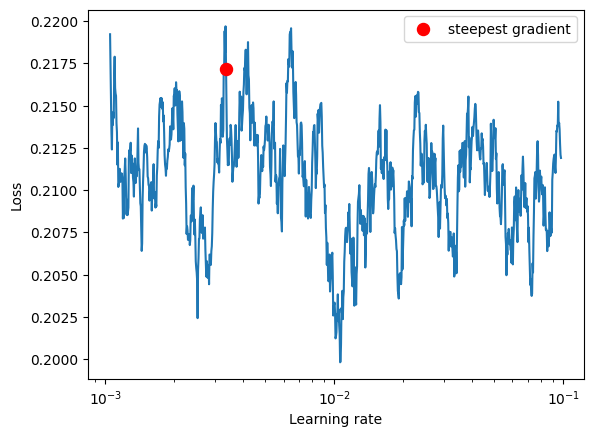

In [22]:
lr_finder.plot()
lr_finder.reset()

## Model Training

In [1]:
BATCH_SIZE = 4096
num_epochs = 50
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.nn import functional as F


from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
# defining transformation
mean = 0.286040484905
std = 0.3530245721340

In [2]:
# defining transformation
transform = transforms.Compose([transforms.ToTensor()]) # Not normalizing as AE

# load the training and test data
trainset = datasets.FashionMNIST(root='../data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST(root='../data', download=True, train=False, transform=transform)

# Use only the top 5000 samples from the training set
trainset = torch.utils.data.Subset(trainset, range(55000))
testset = torch.utils.data.Subset(trainset, range(5000, ))

train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False)
valid_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 100)
        self.fc2 = nn.Linear(100, 30)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(30, 100)
        self.fc2 = nn.Linear(100, 28 * 28)
        self.reshape = nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 
        x = self.reshape(x)
        return x

class StackedAutoEncoder(nn.Module):
    def __init__(self):
        super(StackedAutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x, y = None):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
	torch.cuda.manual_seed(42)
else:
	torch.manual_seed(42)
    
print(device)

cuda


In [4]:
steps_per_epoch = len(trainset)//BATCH_SIZE
print(steps_per_epoch)
total_steps = num_epochs * steps_per_epoch
print(total_steps)

13
650


In [5]:
3.36E-03

0.00336

In [6]:
stacked_ae = StackedAutoEncoder().to(device=device)
criterion = nn.MSELoss()
optimizer = torch.optim.NAdam(stacked_ae.parameters(), lr = 0.015)
T_max = 30
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=2e-3)

In [7]:
# Train data stats
num_batches = len(train_loader)
total_data = len(train_loader.dataset)
# 5 * 32/60000 == 5 / 1875

# Turn on train mode
stacked_ae.train()
# train loss and val loss values
train_loss_per_epoch = []
valid_loss_per_epoch = []
lr_list = []

for epoch in range(num_epochs):
    #============================TRAIN========================================
    train_loss = 0.0
    stacked_ae.train()
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)
    for batch, (imgs, y) in enumerate(train_bar):
        imgs = imgs.to(device)
        
        # Zero grad
        optimizer.zero_grad()
        
        # Forward Pass
        y_pred = stacked_ae(imgs)
        
        # Calculate loss
        loss = criterion(y_pred, imgs)
        
        # Optimization
        loss.backward()
        optimizer.step()
        
        # logging
        batch_loss = loss.item()
        train_loss += batch_loss
        
        #update progress (logging)
        train_bar.set_postfix({'Batch': f'{batch}/{num_batches}', 'Batch loss': f"{batch_loss:.5f}"})
        
    # Calculate average loss over epoch (train_set)
    avg_train_loss = train_loss / num_batches
    train_loss_per_epoch.append(avg_train_loss)
    
    #=============================EVAL=======================================
    stacked_ae.eval()
    val_loss = 0.0
    with torch.no_grad():
        valid_bar = tqdm(valid_loader, desc='Validation', leave = False)
        for (imgs, y) in valid_bar:
            imgs = imgs.to(device)
            # Forward Pass
            y_pred = stacked_ae(imgs)
            
            # Calculate loss
            loss = criterion(y_pred, imgs)
            
            #logging
            val_loss += loss.item() * imgs.size(0)

    # Calculate average loss for val dataset
    avg_val_loss = val_loss / len(valid_loader.dataset) # Explained: # 5 * 32/60000 == 5 / 1875
    valid_loss_per_epoch.append(avg_val_loss)
    
    # Step the scheduler
    if epoch < T_max:
        scheduler.step()
    else:
        pass
    
    # lr
    curr_lr = scheduler.get_last_lr()[0]
    lr_list.append(curr_lr)
    # Print epoch status
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_val_loss:.4f}, lr: {scheduler.get_last_lr()}|{optimizer.param_groups[0]['lr']}")
    


Epoch 1/50:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/50: 100%|██████████| 14/14 [00:12<00:00,  1.16it/s, Batch=13/14, Batch loss=0.06924]


Epoch 1/50, Train Loss: 0.1255, Valid Loss: 0.0734, lr: [0.014964392319893776]|0.014964392319893776


Epoch 2/50: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s, Batch=13/14, Batch loss=0.07040]


Epoch 2/50, Train Loss: 0.0707, Valid Loss: 0.0628, lr: [0.014857959404769736]|0.014857959404769736


Epoch 3/50: 100%|██████████| 14/14 [00:08<00:00,  1.73it/s, Batch=13/14, Batch loss=0.06055]


Epoch 3/50, Train Loss: 0.0585, Valid Loss: 0.0635, lr: [0.014681867355918497]|0.014681867355918497


Epoch 4/50: 100%|██████████| 14/14 [00:09<00:00,  1.47it/s, Batch=13/14, Batch loss=0.04847]


Epoch 4/50, Train Loss: 0.0726, Valid Loss: 0.0522, lr: [0.014438045474676904]|0.014438045474676904


Epoch 5/50: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s, Batch=13/14, Batch loss=0.04278]


Epoch 5/50, Train Loss: 0.0492, Valid Loss: 0.0445, lr: [0.014129165124598851]|0.014129165124598851


Epoch 6/50: 100%|██████████| 14/14 [00:07<00:00,  1.99it/s, Batch=13/14, Batch loss=0.04475]


Epoch 6/50, Train Loss: 0.0471, Valid Loss: 0.0521, lr: [0.013758610463437158]|0.013758610463437158


Epoch 7/50: 100%|██████████| 14/14 [00:06<00:00,  2.09it/s, Batch=13/14, Batch loss=0.04198]


Epoch 7/50, Train Loss: 0.0446, Valid Loss: 0.0456, lr: [0.013330441365603062]|0.013330441365603062


Epoch 8/50: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s, Batch=13/14, Batch loss=0.03971]


Epoch 8/50, Train Loss: 0.0435, Valid Loss: 0.0427, lr: [0.012849348941332578]|0.012849348941332578


Epoch 9/50: 100%|██████████| 14/14 [00:07<00:00,  1.87it/s, Batch=13/14, Batch loss=0.03981]


Epoch 9/50, Train Loss: 0.0420, Valid Loss: 0.0425, lr: [0.012320604139901074]|0.012320604139901074


Epoch 10/50: 100%|██████████| 14/14 [00:06<00:00,  2.12it/s, Batch=13/14, Batch loss=0.03920]


Epoch 10/50, Train Loss: 0.0393, Valid Loss: 0.0435, lr: [0.011749999999999998]|0.011749999999999998


Epoch 11/50: 100%|██████████| 14/14 [00:07<00:00,  1.92it/s, Batch=13/14, Batch loss=0.03754]


Epoch 11/50, Train Loss: 0.0397, Valid Loss: 0.0399, lr: [0.011143788179992701]|0.011143788179992701


Epoch 12/50: 100%|██████████| 14/14 [00:06<00:00,  2.05it/s, Batch=13/14, Batch loss=0.04176]


Epoch 12/50, Train Loss: 0.0389, Valid Loss: 0.0421, lr: [0.010508610463437158]|0.010508610463437158


Epoch 13/50: 100%|██████████| 14/14 [00:07<00:00,  1.84it/s, Batch=13/14, Batch loss=0.03585]


Epoch 13/50, Train Loss: 0.0368, Valid Loss: 0.0374, lr: [0.009851425990315434]|0.009851425990315434


Epoch 14/50: 100%|██████████| 14/14 [00:06<00:00,  2.18it/s, Batch=13/14, Batch loss=0.03529]


Epoch 14/50, Train Loss: 0.0358, Valid Loss: 0.0363, lr: [0.009179435011239748]|0.009179435011239748


Epoch 15/50: 100%|██████████| 14/14 [00:07<00:00,  1.98it/s, Batch=13/14, Batch loss=0.03681]


Epoch 15/50, Train Loss: 0.0357, Valid Loss: 0.0372, lr: [0.0085]|0.0085


Epoch 16/50: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s, Batch=13/14, Batch loss=0.03407]


Epoch 16/50, Train Loss: 0.0365, Valid Loss: 0.0345, lr: [0.007820564988760253]|0.007820564988760253


Epoch 17/50: 100%|██████████| 14/14 [00:12<00:00,  1.11it/s, Batch=13/14, Batch loss=0.03323]


Epoch 17/50, Train Loss: 0.0341, Valid Loss: 0.0337, lr: [0.007148574009684563]|0.007148574009684563


Epoch 18/50: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s, Batch=13/14, Batch loss=0.03269]


Epoch 18/50, Train Loss: 0.0335, Valid Loss: 0.0332, lr: [0.006491389536562841]|0.006491389536562841


Epoch 19/50: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s, Batch=13/14, Batch loss=0.03205]


Epoch 19/50, Train Loss: 0.0324, Valid Loss: 0.0328, lr: [0.005856211820007298]|0.005856211820007298


Epoch 20/50: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s, Batch=13/14, Batch loss=0.03166]


Epoch 20/50, Train Loss: 0.0319, Valid Loss: 0.0322, lr: [0.0052499999999999995]|0.0052499999999999995


Epoch 21/50: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s, Batch=13/14, Batch loss=0.03091]


Epoch 21/50, Train Loss: 0.0314, Valid Loss: 0.0314, lr: [0.004679395860098924]|0.004679395860098924


Epoch 22/50: 100%|██████████| 14/14 [00:09<00:00,  1.54it/s, Batch=13/14, Batch loss=0.03065]


Epoch 22/50, Train Loss: 0.0309, Valid Loss: 0.0310, lr: [0.0041506510586674225]|0.0041506510586674225


Epoch 23/50: 100%|██████████| 14/14 [00:07<00:00,  1.80it/s, Batch=13/14, Batch loss=0.03034]


Epoch 23/50, Train Loss: 0.0305, Valid Loss: 0.0307, lr: [0.003669558634396938]|0.003669558634396938


Epoch 24/50: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s, Batch=13/14, Batch loss=0.02995]


Epoch 24/50, Train Loss: 0.0302, Valid Loss: 0.0303, lr: [0.003241389536562842]|0.003241389536562842


Epoch 25/50: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s, Batch=13/14, Batch loss=0.02973]


Epoch 25/50, Train Loss: 0.0300, Valid Loss: 0.0301, lr: [0.0028708348754011483]|0.0028708348754011483


Epoch 26/50: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s, Batch=13/14, Batch loss=0.02944]


Epoch 26/50, Train Loss: 0.0298, Valid Loss: 0.0298, lr: [0.0025619545253230936]|0.0025619545253230936


Epoch 27/50: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, Batch=13/14, Batch loss=0.02926]


Epoch 27/50, Train Loss: 0.0296, Valid Loss: 0.0296, lr: [0.002318132644081502]|0.002318132644081502


Epoch 28/50: 100%|██████████| 14/14 [00:08<00:00,  1.63it/s, Batch=13/14, Batch loss=0.02907]


Epoch 28/50, Train Loss: 0.0294, Valid Loss: 0.0294, lr: [0.002142040595230263]|0.002142040595230263


Epoch 29/50: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s, Batch=13/14, Batch loss=0.02887]


Epoch 29/50, Train Loss: 0.0292, Valid Loss: 0.0292, lr: [0.002035607680106223]|0.002035607680106223


Epoch 30/50: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s, Batch=13/14, Batch loss=0.02871]


Epoch 30/50, Train Loss: 0.0290, Valid Loss: 0.0290, lr: [0.002]|0.002


Epoch 31/50: 100%|██████████| 14/14 [00:09<00:00,  1.56it/s, Batch=13/14, Batch loss=0.02852]


Epoch 31/50, Train Loss: 0.0288, Valid Loss: 0.0288, lr: [0.002]|0.002


Epoch 32/50: 100%|██████████| 14/14 [00:12<00:00,  1.13it/s, Batch=13/14, Batch loss=0.02834]


Epoch 32/50, Train Loss: 0.0286, Valid Loss: 0.0287, lr: [0.002]|0.002


Epoch 33/50: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s, Batch=13/14, Batch loss=0.02830]


Epoch 33/50, Train Loss: 0.0287, Valid Loss: 0.0286, lr: [0.002]|0.002


Epoch 34/50: 100%|██████████| 14/14 [00:09<00:00,  1.47it/s, Batch=13/14, Batch loss=0.02781]


Epoch 34/50, Train Loss: 0.0282, Valid Loss: 0.0281, lr: [0.002]|0.002


Epoch 35/50: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s, Batch=13/14, Batch loss=0.02769]


Epoch 35/50, Train Loss: 0.0282, Valid Loss: 0.0280, lr: [0.002]|0.002


Epoch 36/50: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s, Batch=13/14, Batch loss=0.02778]


Epoch 36/50, Train Loss: 0.0278, Valid Loss: 0.0284, lr: [0.002]|0.002


Epoch 37/50: 100%|██████████| 14/14 [00:13<00:00,  1.01it/s, Batch=13/14, Batch loss=0.02702]


Epoch 37/50, Train Loss: 0.0275, Valid Loss: 0.0275, lr: [0.002]|0.002


Epoch 38/50: 100%|██████████| 14/14 [00:15<00:00,  1.07s/it, Batch=13/14, Batch loss=0.02678]


Epoch 38/50, Train Loss: 0.0274, Valid Loss: 0.0272, lr: [0.002]|0.002


Epoch 39/50: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s, Batch=13/14, Batch loss=0.02655]


Epoch 39/50, Train Loss: 0.0270, Valid Loss: 0.0270, lr: [0.002]|0.002


Epoch 40/50: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s, Batch=13/14, Batch loss=0.02630]


Epoch 40/50, Train Loss: 0.0267, Valid Loss: 0.0268, lr: [0.002]|0.002


Epoch 41/50: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s, Batch=13/14, Batch loss=0.02619]


Epoch 41/50, Train Loss: 0.0265, Valid Loss: 0.0267, lr: [0.002]|0.002


Epoch 42/50: 100%|██████████| 14/14 [00:07<00:00,  1.86it/s, Batch=13/14, Batch loss=0.02606]


Epoch 42/50, Train Loss: 0.0263, Valid Loss: 0.0265, lr: [0.002]|0.002


Epoch 43/50: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s, Batch=13/14, Batch loss=0.02646]


Epoch 43/50, Train Loss: 0.0264, Valid Loss: 0.0268, lr: [0.002]|0.002


Epoch 44/50: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s, Batch=13/14, Batch loss=0.02553]


Epoch 44/50, Train Loss: 0.0262, Valid Loss: 0.0258, lr: [0.002]|0.002


Epoch 45/50: 100%|██████████| 14/14 [00:07<00:00,  1.82it/s, Batch=13/14, Batch loss=0.02574]


Epoch 45/50, Train Loss: 0.0258, Valid Loss: 0.0260, lr: [0.002]|0.002


Epoch 46/50: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s, Batch=13/14, Batch loss=0.02537]


Epoch 46/50, Train Loss: 0.0258, Valid Loss: 0.0257, lr: [0.002]|0.002


Epoch 47/50: 100%|██████████| 14/14 [00:07<00:00,  1.79it/s, Batch=13/14, Batch loss=0.02539]


Epoch 47/50, Train Loss: 0.0256, Valid Loss: 0.0257, lr: [0.002]|0.002


Epoch 48/50: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s, Batch=13/14, Batch loss=0.02550]


Epoch 48/50, Train Loss: 0.0258, Valid Loss: 0.0259, lr: [0.002]|0.002


Epoch 49/50: 100%|██████████| 14/14 [00:07<00:00,  1.89it/s, Batch=13/14, Batch loss=0.02538]


Epoch 49/50, Train Loss: 0.0257, Valid Loss: 0.0258, lr: [0.002]|0.002


Epoch 50/50: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s, Batch=13/14, Batch loss=0.02543]
                                                         

Epoch 50/50, Train Loss: 0.0257, Valid Loss: 0.0258, lr: [0.002]|0.002


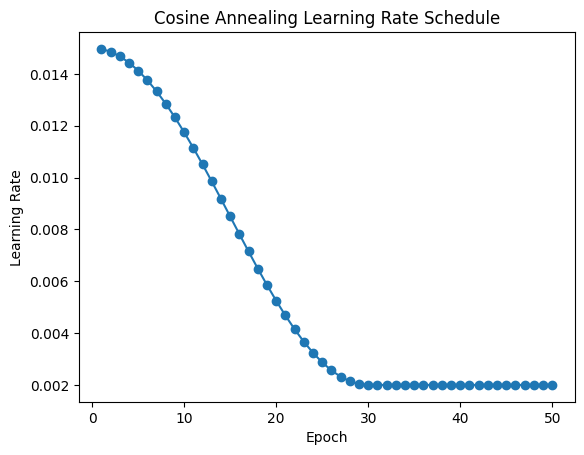

In [8]:
plt.plot(range(1, num_epochs + 1), lr_list, '-o')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Cosine Annealing Learning Rate Schedule')
plt.show()

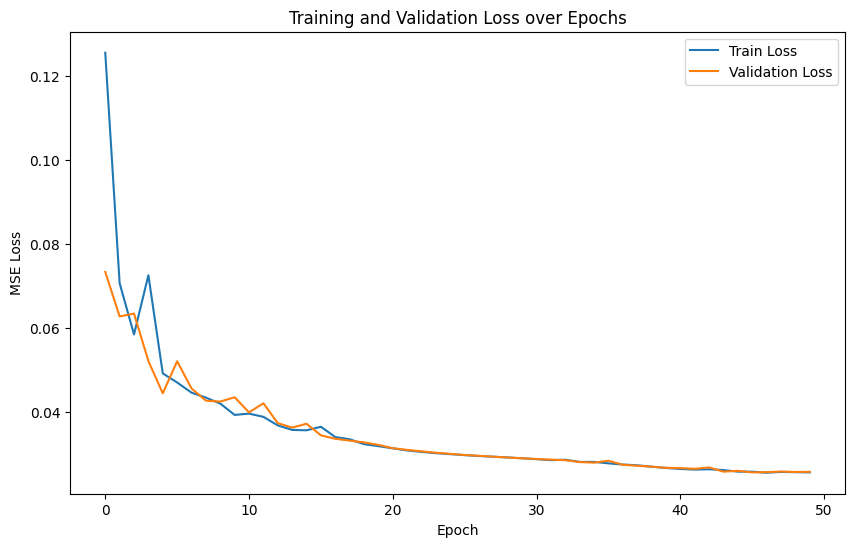

In [9]:
plt.figure(figsize=(10,6))
plt.plot(train_loss_per_epoch, label='Train Loss')
plt.plot(valid_loss_per_epoch, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [10]:
# Save the trained model
torch.save(stacked_ae.state_dict(), 'stacked_autoencoder.pth')
print("\nModel training complete and saved as 'stacked_autoencoder.pth'.")


Model training complete and saved as 'stacked_autoencoder.pth'.


## Visualizing the Reconstructions

torch.Size([5, 1, 28, 28])
(5, 1, 28, 28)
(4096, 1, 28, 28)


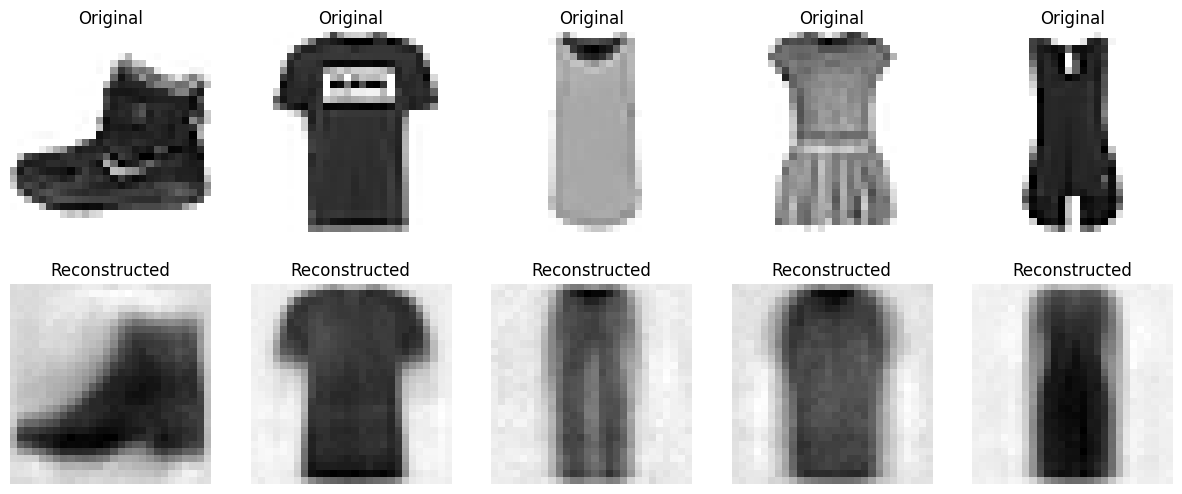

In [11]:
def plot_reconstructions(model, data_loader, n_images=5):
    test_images, _ = next(iter(data_loader))
    with torch.no_grad():
        reconstructions = model(test_images[:n_images].to(device))
    print(reconstructions.shape)
    # Move the images back to CPU for visualization
    test_images = test_images.cpu().numpy()
    reconstructed_images = reconstructions.cpu().numpy()
    print(reconstructed_images.shape)
    print(test_images.shape)
    
    fig, axes = plt.subplots(nrows=2, ncols=n_images, figsize=(15, 6))
    for i in range(n_images):
        # Orignal images
        axes[0, i].imshow(test_images[i].squeeze(), cmap='binary')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        # Generated images
        axes[1, i].imshow(reconstructed_images[i].squeeze(), cmap='binary')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.show()

plot_reconstructions(stacked_ae, valid_loader, n_images=5)